In [1]:
import pandas as pd
import random

# Experiments
import sys
sys.path.append('../..')
from model import run
from model.plot_utils import *
from model.amm.basilisk_amm import ConstantProductPoolState
from model.amm.agents import agent_dict, TradeStrategies

from model import init_utils
from model import processing

# same seed, same parameters = same simulation result
random.seed(42)

initial_state = ConstantProductPoolState(
    tokens={
        'R1': 1000000,
        'R2': 1000000
    },
    trade_fee=0.001,
    fee_function = ConstantProductPoolState.slip_fee
)

agent_d = {
    'Trader1': agent_dict(
        token_list=initial_state.asset_list,
        r_values={'R1': 1000000, 'R2': 1000000},
        trade_strategy=TradeStrategies.random_swaps(amount={'R1': 100, 'R2': 100}, randomize_amount=True)
    ),
    'Trader2': agent_dict(
        token_list=initial_state.asset_list,
        r_values={'R1': 1000000, 'R2': 1000000},
        trade_strategy=TradeStrategies.random_swaps(amount={'R1': 10000, 'R2': 10000}, randomize_amount=True)
    )
}

state = {'state': {'external': {}, 'amm': initial_state, 'agents': agent_d}}
config_dict = init_utils.get_configuration(timesteps=5000)

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (5000, 1, 1, 1)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 1.49s


In [2]:
rdf, agent_df = processing.postprocessing(events, optional_params=['holdings_val'])

[0]


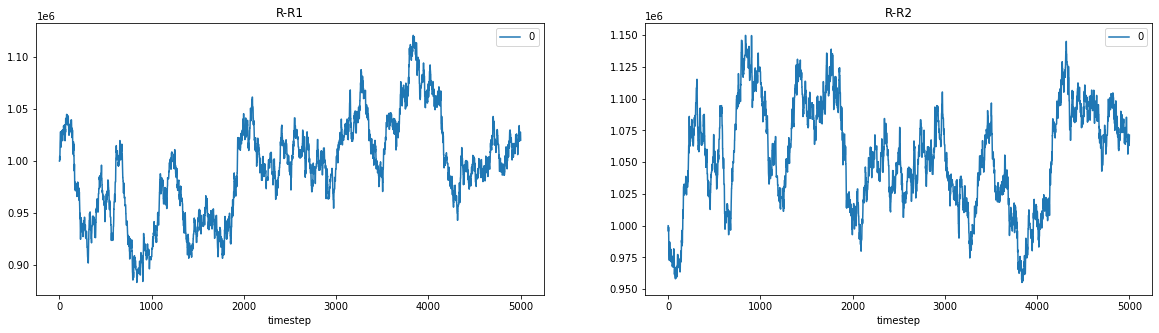

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [3]:

var_list = ['R', 'Q', 'A', 'D']
plot_vars(rdf, var_list)

Trader1 (low volume)
[0]


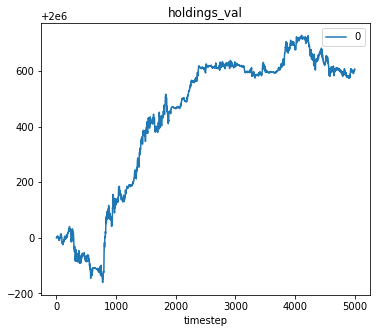

[0]


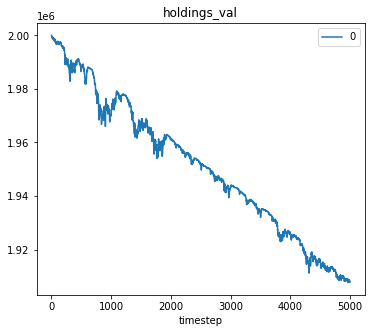

In [4]:
var_list = ['holdings_val']
print('Trader1 (low volume)')
plot_vars(agent_df[agent_df['agent_id'] == 'Trader1'], var_list)

print('Trader2 (high volume)')
plot_vars(agent_df[agent_df['agent_id'] == 'Trader2'], var_list)